The goal here is to calculate the area overlaps between the proposed WFD footrint with DESI and/or 4MOST.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os
import healpy as hp
import numpy as np
import pandas as pd

In [2]:
fontsize = 16
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['xtick.labelsize'] = fontsize-2
mpl.rcParams['ytick.labelsize'] = fontsize-2
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['figure.titlesize'] = fontsize

**Set up some things**

In [3]:
# data characteristics
nside = 256

# path for proposed WFD footprint
data_dir = '/global/homes/a/awan/desc/wfd_footprint/'
filepath = '%sWFDfootprint_nside%s_HEALPixels.csv'%(data_dir, nside)

# data dir for 4MOST and DESI footprints
# saved by the notebooks in static/depth_cuts/overlaps
footprint_dir = '/global/homes/a/awan/desc/4most_desi_data/'

In [4]:
def get_area(pix_arr, nside):
    return len(pix_arr)*hp.nside2pixarea(nside=nside, degrees=True)

def plot_mollview(pix_list, nside, title_append=None, pix_list_2=None):
    # set up the skymaps
    nPix = hp.nside2npix(nside)
    vals = np.zeros(nPix)+1.  # initiate all data to 1
    vals[pix_list] = 5000   # add fake data to the pixels in our list

    if pix_list_2 is not None:
        vals[pix_list_2] = 5   # add fake data to the pixels in our list
        
    if title_append is not None:
        title = '%s\n%.2f deg2; nside %s'%(title_append,
                                           get_area(pix_list, nside),
                                           nside)
    else:
        title = '%.2f deg2; nside %s'%(get_area(pix_list, nside),
                                       nside)
    # plot the skymap
    plt.clf()
    hp.mollview(vals, flip='astro', rot=(0,0,0), min=0, max=10, title=title)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.gcf().set_size_inches(6, 6)
    plt.show()

**Read in all the data: new WFD, 4MOST, DESI footprints**

In [5]:
footprint_pixels = {}

# read in the 4MOST and DESI footprints 
nsides = {}  # store so that we can up/down-grade maps if needed
for key in ['4MOST', 'DESI']:
    for i, file in enumerate([f for f in os.listdir(footprint_dir) if f.startswith(key) \
                              and f.__contains__('ring')]):
        if i>0: raise ValueError('Somethings wrong.')
        print('Reading %s'%file)
        nsides[key] = int(file.split('nside')[-1].split('_')[0])
        print('nside: %s'%nsides[key])
        footprint_pixels[key] = pd.read_csv('%s/%s'%(footprint_dir, file))['pixNum'].values

# read in the proposed WFD pixels
print('## Reading in %s'%filepath)
data = pd.read_csv(filepath)
# extract the pixel numbers
lsst_pix = [int(f) for f in data['pixNum']]

Reading 4MOST_pixels_nside16_ring.csv
nside: 16
Reading DESI_pixels_nside256_ring.csv
nside: 256
## Reading in /global/homes/a/awan/desc/wfd_footprint/WFDfootprint_nside256_HEALPixels.csv


**Get all the footprints to be on the same resolution**

In [6]:
# lets see if need to degrade things if they are not at nside=256
for key in footprint_pixels.keys():
    if nsides[key]!=nside:
        print('Changing %s footprint from nside %s to %s'%(key, nsides[key], nside))
        # create an array for hp.ud_grade
        npix = hp.nside2npix(nside=nsides[key])
        vals = np.zeros(npix)+5000  # random values
        footprint = vals.view(np.ma.MaskedArray)  # view as masked array
        footprint.mask = [True]*npix   # initialze as all masked
        footprint.mask[footprint_pixels[key]] = False   # unmask the footprint
    
        # now degrade
        footprint.fill_value = -100   # needed since hp will be doing some interp
        footprint = hp.ud_grade(footprint, nside_out=nside, pess=True)
        footprint_pixels[key] = np.where(footprint.data>5)[0]

Changing 4MOST footprint from nside 16 to 256


**Plot things out**

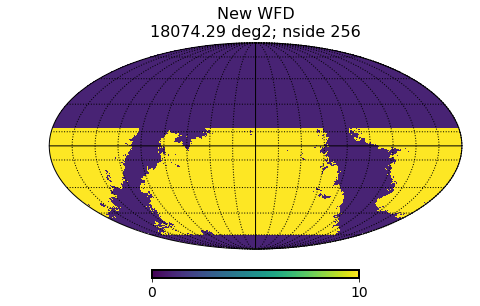

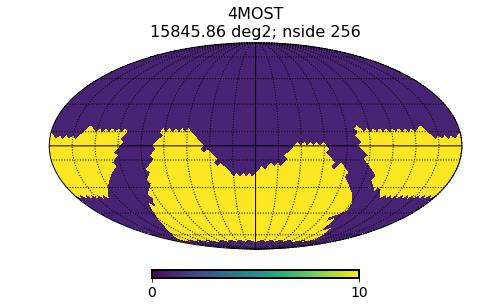

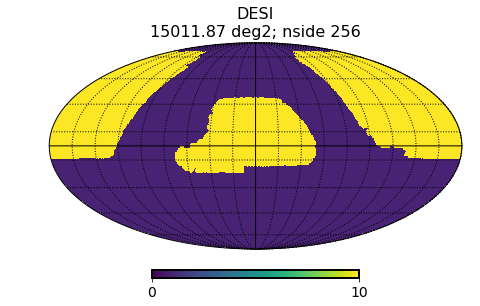

In [7]:
# plot the proposed WFD
plot_mollview(pix_list=lsst_pix, nside=nside, title_append='New WFD')

# plot the 4MOST, DESI footprints
for key in footprint_pixels:
    plot_mollview(pix_list=footprint_pixels[key], nside=nside, title_append=key)

**Calculate the overlaps**

## Calculating the overlaps .. 
## Calculating the overlap with 4MOST .. 


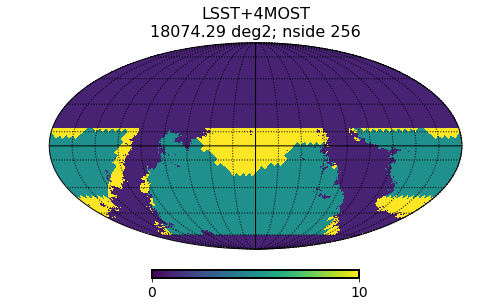

## Calculating the overlap with DESI .. 


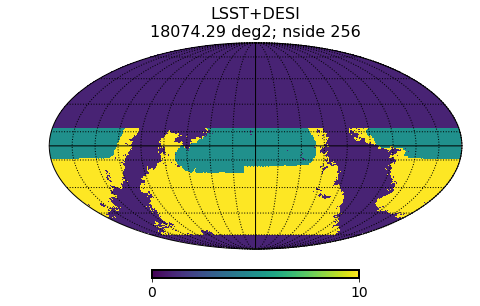

## Calculating the overlap with LSST+4MOST/DESI .. 


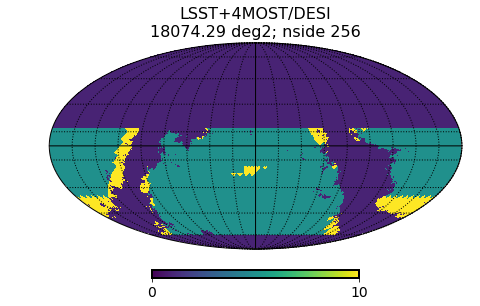

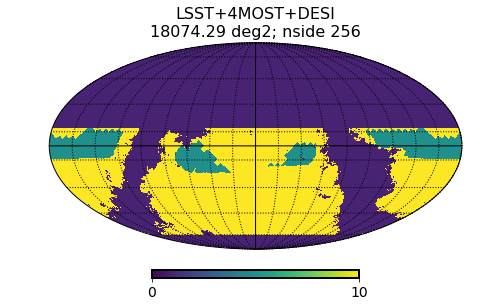

CPU times: user 2.73 s, sys: 1.37 s, total: 4.1 s
Wall time: 2.69 s


In [8]:
%%time

overlap_area, areas = {}, {}
areas['New WFD'] = get_area(pix_arr=lsst_pix, nside=nside)
# ---------------------------------------------------------------
# calculate the overlap
print('## Calculating the overlaps .. ')
# ------------------------------------------------
# first overlap with 4most, desi only
for key in footprint_pixels:
    print('## Calculating the overlap with %s .. '%key)
    overlap = list( set(lsst_pix)-(set(lsst_pix)-\
                                   set(footprint_pixels[key])
                                  )
                  )
    overlap_area['LSST+%s'%key] = get_area(pix_arr=overlap, nside=nside)

    # plot the skymap
    plot_mollview(pix_list=lsst_pix, nside=nside,
                  title_append='LSST+%s'%key, pix_list_2=overlap)
                
    # store the area for later 
    areas[key] = get_area(pix_arr=footprint_pixels[key], nside=nside)
# ------------------------------------------------
# now get the overlap with 4most OR desi
key = 'LSST+4MOST/DESI'
print('## Calculating the overlap with %s .. '%key)

overlap = list( set(lsst_pix)-(set(lsst_pix)- \
                               set(footprint_pixels['4MOST'])- \
                               set(footprint_pixels['DESI'])
                              ) 
              )

# plot the skymap
plot_mollview(pix_list=lsst_pix, nside=nside,
              title_append=key, pix_list_2=overlap)

overlap_area[key] = get_area(pix_arr=overlap, nside=nside)

# ------------------------------------------------
# now get the overlap with 4most AND desi
key = 'LSST+4MOST+DESI'
#print('## Calculating the overlap with %s .. '%key)

overlap = set( footprint_pixels['4MOST'])-(set(footprint_pixels['4MOST'])- \
                                           set(footprint_pixels['DESI'] )
                                          )
overlap = list(set(lsst_pix)-(set(lsst_pix)-set(overlap)))

# plot the skymap
plot_mollview(pix_list=lsst_pix, nside=nside,
              title_append=key, pix_list_2=overlap)

overlap_area[key] = get_area(pix_arr=overlap, nside=nside)

**Print out the total areas in a markdown**

In [9]:
header, header2, row =  '|  | ', '| --- | ', '| Total area (deg2) | '
for key in areas:
    header += '%s | ' %key
    header2 += '--- | '
    row += ' %.2f |'%(areas[key])
    
print('%s\n%s\n%s'%(header, header2, row))

|  | New WFD | 4MOST | DESI | 
| --- | --- | --- | --- | 
| Total area (deg2) |  18074.29 | 15845.86 | 15011.87 |


**Print out the overlap areas in a markdown**

In [10]:
header, header2, row =  '| dbname | ', '| --- | ', '| New WFD | '
for key in overlap_area:
    header += '%s | ' %key
    header2 += '--- | '
    row += ' %.f |'%(overlap_area[key])
    
print('%s\n%s\n%s'%(header, header2, row))

| dbname | LSST+4MOST | LSST+DESI | LSST+4MOST/DESI | LSST+4MOST+DESI | 
| --- | --- | --- | --- | --- | 
| New WFD |  13764 | 5932 | 16408 | 3288 |
